In [1]:
#!/usr/bin/env python

import torch
from torch import nn
from torch import optim
from torch import Tensor
from torch.nn import functional as F
import dlc_practical_prologue as prologue
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
%matplotlib notebook

In [ ]:
##########################################à
#CONTENT
# in the first part we train a net w. 1 conv net to learn the digits of 14x14 pics
# in the second part we train a net w. 2 conv net to learn the digits of 14x14 pics
# in the third part we train the standard con nn to learn mnist
# sample data are always normalized and use one hot label encoding

In [2]:
#generate_data
mnist_train_set = MNIST('./data/mnist/', train = True, download = False)
mnist_test_set =  MNIST('./data/mnist/', train = False, download = False)

N = 10**3
train_input,train_target,train_classes,test_input,test_target,test_classes=prologue.generate_pair_sets(N)

In [3]:
train_input.shape

torch.Size([1000, 2, 14, 14])

In [4]:
#convert target to one_hot_label
train_target = prologue.convert_to_one_hot_labels(train_target, train_target)
test_target = prologue.convert_to_one_hot_labels(test_target, test_target)

#convert classes to one_hot_label. Faster way to do it? 
temp1 = prologue.convert_to_one_hot_labels(train_classes[:,0], train_classes[:,0])
temp2 = prologue.convert_to_one_hot_labels(train_classes[:,1], train_classes[:,1])        
train_classes = torch.cat((temp1.unsqueeze(2), temp2.unsqueeze(2)), dim = 2)
train_classes = torch.transpose(train_classes, 1, 2)

temp1 = prologue.convert_to_one_hot_labels(test_classes[:,0], test_classes[:,0])
temp2 = prologue.convert_to_one_hot_labels(test_classes[:,1], test_classes[:,1])        
test_classes = torch.cat((temp1.unsqueeze(2), temp2.unsqueeze(2)), dim = 2)
test_classes = torch.transpose(test_classes, 1, 2)

test_classes.shape, train_classes.shape

(torch.Size([1000, 2, 10]), torch.Size([1000, 2, 10]))

<IPython.core.display.Javascript object>


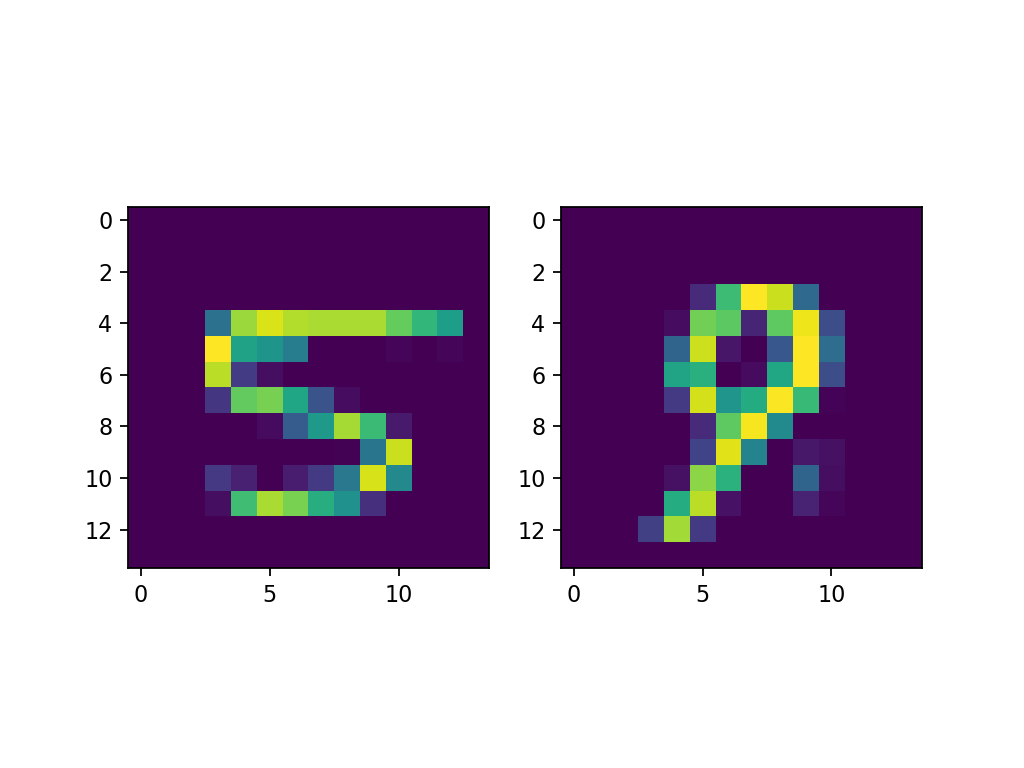

classes
tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])
target
tensor([0, 1])


In [5]:
#just a (visual) check
index = torch.randint(1000, (1,)).item()
fig = plt.figure()
fig.add_subplot(1, 2, 1)
plt.imshow(train_input[index][0])
fig.add_subplot(1, 2, 2)
plt.imshow(train_input[index][1])
print('classes')
print(train_classes[index][0])
print(train_classes[index][1])
print('target')
print(train_target[index])

In [6]:
#convert to float
train_input = train_input.float()
train_target = train_target.float()

test_input = test_input.float()
test_target = test_target.float()

train_classes = train_classes.float()
test_classes = test_classes.float()

In [7]:
#taking just the first digit picture and using classes as target
train_input = train_input[:,0,:,:]
test_input = test_input[:,0,:,:]

train_input = train_input.unsqueeze(1)
test_input = test_input.unsqueeze(1)

train_target = train_classes[:,0]
test_target = test_classes[:,0]

In [8]:
#Claim: the data is not normalized
print('media train {:0.2f}'.format(train_input.mean()), '; std train {:0.2f}'.format( train_input.std()))
print('media test {:0.2f}'.format(test_input.mean()), '; std test {:0.2f}'.format( test_input.std()))

media train 33.33 ; std train 71.40
media test 33.42 ; std test 71.51


In [9]:
#normalize the data and check
mu, std = train_input.mean(), train_input.std()
train_input = train_input.sub_(mu).div_(std)
test_input = test_input.sub_(mu).div_(std)

print('media train {:0.2f}'.format(train_input.mean()), '; std train {:0.2f}'.format( train_input.std()))
print('media test {:0.2f}'.format(test_input.mean()), '; std test {:0.2f}'.format( test_input.std()))

media train 0.00 ; std train 1.00
media test 0.00 ; std test 1.00


In [10]:
#Base functions adapted from the practicals
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        #self.conv2 = nn.Conv2d(32, 64, kernel_size=2)
        self.fc1 = nn.Linear(512, 60)
        self.fc2 = nn.Linear(60, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=3, stride=3))
        #x = self.conv2(x)
        #x = F.relu(F.max_pool2d(x, kernel_size=3, stride=3))
        x = F.relu(self.fc1(x.view(-1, 512)))
        x = F.softmax(self.fc2(x), dim=1)
        return x

In [11]:
#define training function
def train_model(model, train_input, train_target, mini_batch_size, nb_epochs):
    criterion = nn.MSELoss()
    eta = 1e-1

    for e in range(nb_epochs):
        acc_loss = 0

        for b in range(0, train_input.size(0), mini_batch_size):
            output = model(train_input.narrow(0, b, mini_batch_size))
            loss = criterion(output, train_target.narrow(0, b, mini_batch_size) )
            acc_loss = acc_loss + loss.item()
            model.zero_grad()
            loss.backward()

            with torch.no_grad():
                for p in model.parameters():
                    p -= eta * p.grad

        print(e, acc_loss)

In [12]:
#define compute error function
def compute_nb_errors(model, input, target, mini_batch_size):
    nb_errors = 0

    _, true_class = target.max(1)
    for b in range(0, input.size(0), mini_batch_size):
        output = model(input.narrow(0, b, mini_batch_size))
        _, predicted_classes = output.max(1)
        for k in range(mini_batch_size):
            if true_class[b + k]!=predicted_classes[k]:
                nb_errors = nb_errors + 1

    return nb_errors

In [13]:
#initialize model w batch size and epochs
mini_batch_size = 100
nb_epochs = 500
model = Net()

In [14]:
#train model
train_model(model, train_input, train_target, mini_batch_size, nb_epochs)

0 0.9036754220724106
1 0.9000871106982231
2 0.896905817091465
3 0.8939975798130035
4 0.8912285342812538
5 0.8885706812143326
6 0.8859388157725334
7 0.8832881972193718
8 0.8805559128522873
9 0.8777418732643127
10 0.8748259022831917
11 0.8717670291662216
12 0.868564210832119
13 0.8652187436819077
14 0.8617368936538696
15 0.858116939663887
16 0.8543612286448479
17 0.850430354475975
18 0.8463183268904686
19 0.8420405238866806
20 0.8376028537750244
21 0.8329994156956673
22 0.8282316997647285
23 0.8232867419719696
24 0.8181588873267174
25 0.8128382787108421
26 0.8073176890611649
27 0.8015775606036186
28 0.7956192493438721
29 0.7894356995820999
30 0.7830017134547234
31 0.7763036265969276
32 0.7693178951740265
33 0.7620387524366379
34 0.7544447183609009
35 0.74652498960495
36 0.738255001604557
37 0.7296355813741684
38 0.7206465601921082
39 0.7112901136279106
40 0.7015702426433563
41 0.6914923265576363
42 0.6810717582702637
43 0.6703229323029518
44 0.6592774279415607
45 0.6479640267789364
46 0.

353 0.052635989151895046
354 0.05246404651552439
355 0.05230130581185222
356 0.05213376856409013
357 0.05196695076301694
358 0.05180042143911123
359 0.05164155806414783
360 0.051473268773406744
361 0.051314171170815825
362 0.05115144397132099
363 0.050988688599318266
364 0.05083215679042041
365 0.050672249402850866
366 0.050513851922005415
367 0.05035778437741101
368 0.050199356861412525
369 0.05004442064091563
370 0.04989257804118097
371 0.04973374377004802
372 0.04958654893562198
373 0.0494333419483155
374 0.049280517967417836
375 0.04913167585618794
376 0.04898334667086601
377 0.04883058927953243
378 0.048686482943594456
379 0.04853189643472433
380 0.048393300967291
381 0.04824333940632641
382 0.04810054413974285
383 0.0479500750079751
384 0.04781360784545541
385 0.047665587393566966
386 0.047521719709038734
387 0.047384758247062564
388 0.04724116972647607
389 0.04710178938694298
390 0.04695690516382456
391 0.04682319168932736
392 0.04668275383301079
393 0.046545449178665876
394 0.0

In [15]:
#test error
nb_test_errors = compute_nb_errors(model, test_input, test_target, mini_batch_size)
print('test error Net {:0.2f}% {:d}/{:d}'.format((100 * nb_test_errors) / test_input.size(0),
                                                      nb_test_errors, test_input.size(0)))

test error Net 7.10% 71/1000


In [16]:
#shuffle data
permuted_index = torch.randperm(train_input.size()[0])
train_input_shuffled = train_input[permuted_index].detach()
train_target_shuffled = train_target[permuted_index].detach()

In [17]:
(train_input == train_input_shuffled).all(), (train_target == train_target_shuffled).all()

(tensor(False), tensor(False))

<IPython.core.display.Javascript object>


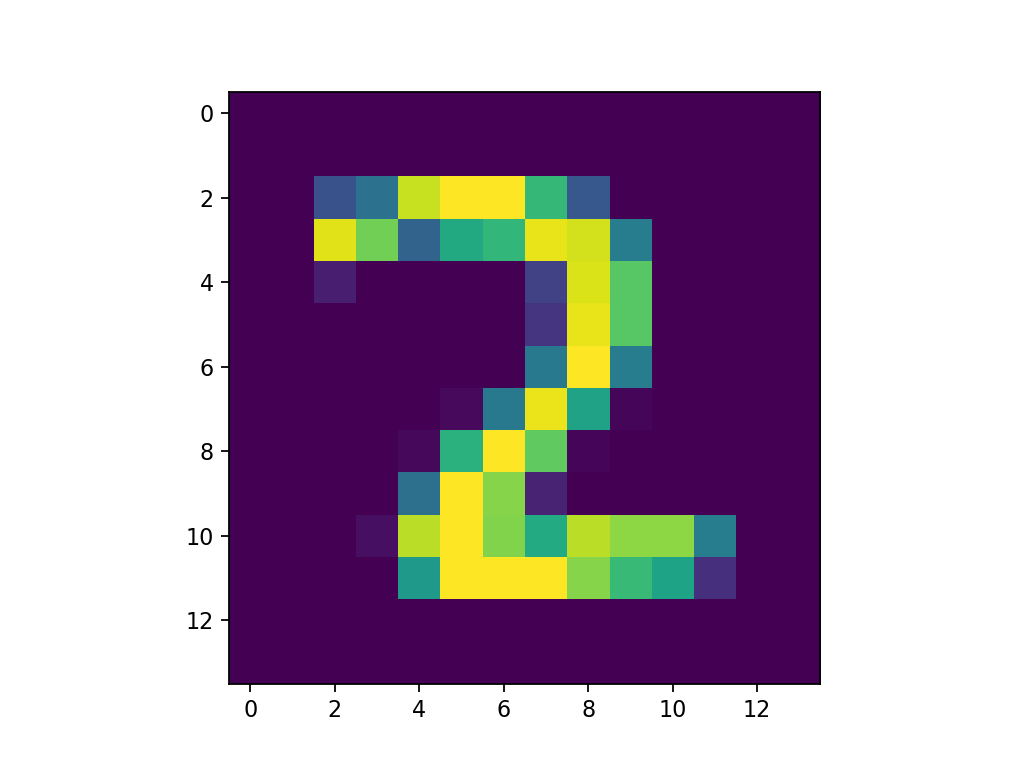

target
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])


In [18]:
#just a (visual) check
index = torch.randint(1000, (1,)).item()
fig = plt.figure()
plt.imshow(train_input_shuffled[index][0])
print('target')
print(train_target_shuffled[index])

In [19]:
#redefine model and train
#initialize model w batch size and epochs
mini_batch_size = 100
nb_epochs = 500
model2 = Net()

train_model(model2, train_input_shuffled, train_target_shuffled, mini_batch_size, nb_epochs)

0 0.9041045606136322
1 0.9005029797554016
2 0.8970275819301605
3 0.8936341404914856
4 0.8903180882334709
5 0.8871198743581772
6 0.8840030506253242
7 0.8808909356594086
8 0.8777486979961395
9 0.8745806962251663
10 0.8713780120015144
11 0.8681296110153198
12 0.8647818565368652
13 0.8612885996699333
14 0.857623927295208
15 0.8537873327732086
16 0.8497608527541161
17 0.8455308303236961
18 0.8410811349749565
19 0.8363920971751213
20 0.8314479887485504
21 0.8262342214584351
22 0.8207347840070724
23 0.814931146800518
24 0.808802604675293
25 0.8023400232195854
26 0.7955415695905685
27 0.7883984223008156
28 0.7809078022837639
29 0.7730717808008194
30 0.7648970782756805
31 0.7563924416899681
32 0.7475773319602013
33 0.7384820282459259
34 0.729141041636467
35 0.7195799276232719
36 0.7098507434129715
37 0.6999667510390282
38 0.6899605840444565
39 0.6798896342515945
40 0.6697711758315563
41 0.6596225239336491
42 0.6494752503931522
43 0.6393350400030613
44 0.6291975751519203
45 0.6190817058086395
46

351 0.048195109935477376
352 0.04803136130794883
353 0.0478643043898046
354 0.04770205239765346
355 0.04754321835935116
356 0.04737498355098069
357 0.047223674366250634
358 0.047058222349733114
359 0.046903406735509634
360 0.04674079944379628
361 0.046588626224547625
362 0.04642998497001827
363 0.0462731656152755
364 0.04612014116719365
365 0.04596893978305161
366 0.045812316006049514
367 0.04566166969016194
368 0.04550654930062592
369 0.0453620960470289
370 0.045209367759525776
371 0.045062468852847815
372 0.04491287167184055
373 0.04476751736365259
374 0.044619384687393904
375 0.044474514899775386
376 0.04432959738187492
377 0.04418453760445118
378 0.04404272371903062
379 0.04389892774634063
380 0.04375566984526813
381 0.04361491068266332
382 0.0434728458058089
383 0.043336930219084024
384 0.04319291212595999
385 0.04305736720561981
386 0.04292167886160314
387 0.042782158590853214
388 0.04264606651850045
389 0.0425056463573128
390 0.04237582511268556
391 0.042239981004968286
392 0.04

In [20]:
#test error
nb_test_errors = compute_nb_errors(model2, test_input, test_target, mini_batch_size)
print('test error Net {:0.2f}% {:d}/{:d}'.format((100 * nb_test_errors) / test_input.size(0),
                                                      nb_test_errors, test_input.size(0)))

test error Net 7.50% 75/1000


In [21]:
#########################################################################################################
#below we do the same things we did before but using a network 
# with 2 convolutional layers, like in the original we used on MNIST
# The results is slightly worse. My guess is because of the small dimensions 
# of the pictures
#########################################################################################################

In [22]:
#Base functions adapted from the practicals
class Net2Conv(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=2)
        self.fc1 = nn.Linear(64, 60)
        self.fc2 = nn.Linear(60, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=3, stride=3))
        x = self.conv2(x)
        x = F.relu(F.max_pool2d(x, kernel_size=3, stride=3))
        x = F.relu(self.fc1(x.view(-1, 64)))
        x = F.softmax(self.fc2(x), dim=1)
        return x

In [23]:
#initialize model w batch size and epochs
mini_batch_size = 100
nb_epochs = 500
model = Net2Conv()

#train model
train_model(model, train_input, train_target, mini_batch_size, nb_epochs)

0 0.9035653099417686
1 0.9032763913273811
2 0.9029929712414742
3 0.902717836201191
4 0.9024529680609703
5 0.9021958708763123
6 0.9019449353218079
7 0.901700884103775
8 0.9014626070857048
9 0.9012294709682465
10 0.9010018482804298
11 0.9007793888449669
12 0.9005618095397949
13 0.9003471881151199
14 0.9001363217830658
15 0.899930365383625
16 0.8997299075126648
17 0.8995347693562508
18 0.8993437439203262
19 0.8991556987166405
20 0.8989704251289368
21 0.8987872526049614
22 0.8986076638102531
23 0.8984317630529404
24 0.8982591778039932
25 0.8980888053774834
26 0.8979206159710884
27 0.8977561444044113
28 0.897594727575779
29 0.897434800863266
30 0.8972762823104858
31 0.8971185088157654
32 0.8969616591930389
33 0.8968064934015274
34 0.8966534733772278
35 0.8965017348527908
36 0.8963509574532509
37 0.8962011709809303
38 0.896052747964859
39 0.8959052413702011
40 0.8957585468888283
41 0.8956124261021614
42 0.8954654186964035
43 0.895318366587162
44 0.8951721489429474
45 0.8950255513191223
46 0.

364 0.45506567507982254
365 0.4517795033752918
366 0.44850030541419983
367 0.4452337771654129
368 0.44196566194295883
369 0.43869585916399956
370 0.4354373514652252
371 0.432185135781765
372 0.4289378970861435
373 0.42568910866975784
374 0.4224551096558571
375 0.41922659426927567
376 0.4160082936286926
377 0.41280247643589973
378 0.4096071757376194
379 0.40641190111637115
380 0.4032270275056362
381 0.40004848688840866
382 0.3968743085861206
383 0.39370985701680183
384 0.3905509300529957
385 0.3873894475400448
386 0.38423727825284004
387 0.38108964264392853
388 0.377958532422781
389 0.37483127787709236
390 0.37171243131160736
391 0.3685997575521469
392 0.365496002137661
393 0.36240821704268456
394 0.3593321740627289
395 0.35626521334052086
396 0.35321421921253204
397 0.3501735031604767
398 0.3471425175666809
399 0.34412532672286034
400 0.34111899323761463
401 0.3381306044757366
402 0.33513227477669716
403 0.33214788511395454
404 0.32917011342942715
405 0.3262151349335909
406 0.323268737

In [24]:
#test error
nb_test_errors = compute_nb_errors(model, test_input, test_target, mini_batch_size)
print('test error Net {:0.2f}% {:d}/{:d}'.format((100 * nb_test_errors) / test_input.size(0),
                                                      nb_test_errors, test_input.size(0)))

test error Net 12.50% 125/1000


In [25]:
#do it again on shuffled data 

mini_batch_size = 100
nb_epochs = 500
model2 = Net()

#training
train_model(model2, train_input_shuffled, train_target_shuffled, mini_batch_size, nb_epochs)

0 0.9087758809328079
1 0.9029927551746368
2 0.8987272754311562
3 0.8951572701334953
4 0.8919356390833855
5 0.8889011144638062
6 0.8859900906682014
7 0.8831402510404587
8 0.880277119576931
9 0.8773639053106308
10 0.8743487522006035
11 0.8712445423007011
12 0.8680347725749016
13 0.8646685555577278
14 0.8611869886517525
15 0.8575736060738564
16 0.8538090959191322
17 0.8499015867710114
18 0.8458392694592476
19 0.8416009992361069
20 0.8371856808662415
21 0.8325774893164635
22 0.8277495726943016
23 0.8226887658238411
24 0.8173716738820076
25 0.811781108379364
26 0.8059032782912254
27 0.7997281402349472
28 0.7932470664381981
29 0.7864486426115036
30 0.7793375551700592
31 0.7718981355428696
32 0.7641283646225929
33 0.7560405731201172
34 0.7476506009697914
35 0.7389723137021065
36 0.7300190851092339
37 0.7208126410841942
38 0.7113772928714752
39 0.7017365470528603
40 0.6919305771589279
41 0.6819715052843094
42 0.671889916062355
43 0.6617307886481285
44 0.6515139974653721
45 0.6412703730165958
4

352 0.04915757942944765
353 0.048962559551000595
354 0.048762964783236384
355 0.04856332391500473
356 0.04836728656664491
357 0.048168569803237915
358 0.04797664494253695
359 0.047778354259207845
360 0.047592276241630316
361 0.04739435715600848
362 0.04719933168962598
363 0.04701399407349527
364 0.04682153672911227
365 0.046630045399069786
366 0.04644514434039593
367 0.04625941580161452
368 0.046066798036918044
369 0.045877695782110095
370 0.045694779604673386
371 0.04550997028127313
372 0.045326102059334517
373 0.04513998958282173
374 0.04496074374765158
375 0.04477763385511935
376 0.04459625156596303
377 0.044419331941753626
378 0.044234131230041385
379 0.04406070080585778
380 0.04387957416474819
381 0.043701327638700604
382 0.043528514448553324
383 0.043352463049814105
384 0.043174780206754804
385 0.04300346947275102
386 0.042828611796721816
387 0.04265554202720523
388 0.04248315282166004
389 0.04231417924165726
390 0.042138418182730675
391 0.04197327187284827
392 0.0418034247122705

In [26]:
#test_error
nb_test_errors = compute_nb_errors(model2, test_input, test_target, mini_batch_size)
print('test error Net {:0.2f}% {:d}/{:d}'.format((100 * nb_test_errors) / test_input.size(0),
                                                      nb_test_errors, test_input.size(0)))

test error Net 6.40% 64/1000


In [27]:
#####################################################################
# The following is just the standard nn trained on usual mnist mnist.
# Even if apparently our version is just a scaled down-version, it
# works a lot worse. My guess is that when it due to the noise added 
# when we decreased the dimension of the picture (in prologue there an avg
# pooling to generate the pitures from MNIST)
####################################################################

In [28]:
#the following block just imports th data from mnist (again) 
mnist_train_set = MNIST('/mnist/', train = True, download = False)
mnist_test_set = MNIST('/mnist/', train = False, download = False)

train_input = mnist_train_set.data.view(-1, 1, 28, 28).float()
train_target = mnist_train_set.targets
test_input = mnist_test_set.data.view(-1, 1, 28, 28).float()
test_target = mnist_test_set.targets

#take the first 1000 samples
train_input = train_input[:1000]
train_target = train_target[:1000]

#onehotlabel
train_target = prologue.convert_to_one_hot_labels(train_input, train_target)
test_target = prologue.convert_to_one_hot_labels(test_input, test_target)

#normalize
mu, std = train_input.mean(), train_input.std()
train_input = train_input.sub_(mu).div_(std)
test_input = test_input.sub_(mu).div_(std)

#check normalization 
print('media train', train_input.mean(), 'std train', train_input.std())
print('media test', test_input.mean(), 'std test', test_input.std())

media train tensor(5.0136e-08) std train tensor(1.)
media test tensor(0.0140) std test tensor(1.0175)


In [29]:
#just a check 
train_input.shape, train_target.shape, test_input.shape, test_target.shape

(torch.Size([1000, 1, 28, 28]),
 torch.Size([1000, 10]),
 torch.Size([10000, 1, 28, 28]),
 torch.Size([10000, 10]))

In [30]:
class NetMnist(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(256, 200)
        self.fc2 = nn.Linear(200, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=3, stride=3))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
        x = F.relu(self.fc1(x.view(-1, 256)))
        x = self.fc2(x)
        return x

In [31]:
mini_batch_size = 100
nb_epochs = 200
mnist_model = NetMnist()

In [32]:
mnist_model(train_input[:100]).shape

torch.Size([100, 10])

In [33]:
#train mnist_model
train_model(mnist_model, train_input, train_target, mini_batch_size, nb_epochs)

0 0.911361426115036
1 0.8048926368355751
2 0.7394818589091301
3 0.6785367652773857
4 0.622793897986412
5 0.5738602019846439
6 0.5359404347836971
7 0.5142510905861855
8 0.4817890338599682
9 0.44721636921167374
10 0.4283876530826092
11 0.41287681832909584
12 0.38865504786372185
13 0.36811187863349915
14 0.3856956586241722
15 0.3624178171157837
16 0.331361748278141
17 0.3207848332822323
18 0.311607975512743
19 0.3050704598426819
20 0.3032641354948282
21 0.29284653812646866
22 0.2783588021993637
23 0.2728775441646576
24 0.2737807407975197
25 0.2645682245492935
26 0.2522892616689205
27 0.24557631462812424
28 0.2396646924316883
29 0.2338339127600193
30 0.22798790037631989
31 0.22158052027225494
32 0.215309901162982
33 0.21498225256800652
34 0.21721225418150425
35 0.2033044919371605
36 0.19836490787565708
37 0.20539618283510208
38 0.19784545712172985
39 0.18563373666256666
40 0.1824542647227645
41 0.18658635765314102
42 0.18846797943115234
43 0.17652654647827148
44 0.1695658527314663
45 0.172

In [34]:
#test error
nb_test_errors = compute_nb_errors(mnist_model, test_input, test_target, mini_batch_size)
print('test error Net {:0.2f}% {:d}/{:d}'.format((100 * nb_test_errors) / test_input.size(0),
                                                      nb_test_errors, test_input.size(0)))

test error Net 4.28% 428/10000
